This will use all dataset
Note: 15/12/2024: im using this

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [15]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [16]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [17]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [18]:
def extract_entry_id(header):
    """Extract entry ID between first and second '|' characters if present, otherwise return as is"""
    if '|' in header:
        try:
            return header.split('|')[1]
        except:
            print(f"Warning: Could not parse header with pipes: {header}")
            return header
    else:
        # If no pipes, assume it's already an ID
        return header

def load_complete_data(mode='train', exclude_emb=False):
    """
    Load data line by line ensuring perfect matching between FASTA and ProtT5 files
    """
    # Set paths based on mode
    if mode == 'train':
        pos_fasta = '../../data/train/fasta/positive_sites.fasta'
        neg_fasta = '../../data/train/fasta/negative_sites.fasta'
        pos_prott5_path = '../../data/train/features/train_positive_ProtT5-XL-UniRef50.csv'
        neg_prott5_path = '../../data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
        struct_path = "../data/processed_features_train_latest.csv"
    else:  # test
        pos_fasta = '../../data/test/fasta/test_positive_sites.fasta'
        neg_fasta = '../../data/test/fasta/test_negative_sites.fasta'
        pos_prott5_path = '../../data/test/features/test_positive_ProtT5-XL-UniRef50.csv'
        neg_prott5_path = '../../data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
        struct_path = "../data/processed_features_test_latest.csv"

    print("Loading structure data first...")
    struct_data = pd.read_csv(struct_path)
    # Clean structure data entry IDs
    struct_data['entry'] = struct_data['entry'].apply(lambda x: extract_entry_id(x) if isinstance(x, str) else x)
    
    # Create dictionary for quick lookup of structure data
    struct_dict = {}
    for _, row in struct_data.iterrows():
        key = (row['entry'], row['pos'])
        struct_dict[key] = row.to_dict()

    print("\nProcessing positive data...")
    positive_data = []
    
    # Process positive data
    with open(pos_fasta) as fasta_file:
        fasta_lines = fasta_file.readlines()
    
    # Read ProtT5 positive data
    prott5_pos = pd.read_csv(pos_prott5_path, header=None)
    
    for i in range(0, len(fasta_lines), 2):
        # Process FASTA header
        header = fasta_lines[i].strip()[1:]  # remove '>'
        sequence = fasta_lines[i + 1].strip()
        
        # Parse header - extract entry ID between | characters and position after |-|
        entry = extract_entry_id(header.split('|-|')[0])
        pos = int(header.split('|-|')[1])
        
        # Get corresponding ProtT5 line
        prott5_line = prott5_pos.iloc[i//2]
        
        # Create data entry
        data_entry = {
            'entry': entry,
            'pos': pos,
            'sequence': sequence,
            'label': 1,
            'has_structure': False
        }
        
        # Add ProtT5 embeddings if requested
        if not exclude_emb:
            for j in range(2, len(prott5_line)):  # skip entry and pos columns
                data_entry[f'emb_{j-2}'] = prott5_line[j]
        
        # Add structure features if available
        if (entry, pos) in struct_dict:
            data_entry['has_structure'] = True
            struct_features = struct_dict[(entry, pos)]
            for key, value in struct_features.items():
                if key not in ['entry', 'pos', 'sequence', 'label']:
                    data_entry[key] = value
        
        positive_data.append(data_entry)
    
    print("Processing negative data...")
    negative_data = []
    
    # Process negative data
    with open(neg_fasta) as fasta_file:
        fasta_lines = fasta_file.readlines()
    
    # Read ProtT5 negative data
    prott5_neg = pd.read_csv(neg_prott5_path, header=None)
    
    for i in range(0, len(fasta_lines), 2):
        # Process FASTA header
        header = fasta_lines[i].strip()[1:]  # remove '>'
        sequence = fasta_lines[i + 1].strip()
        
        # Parse header - extract entry ID between | characters and position after |-|
        entry = extract_entry_id(header.split('|-|')[0])
        pos = int(header.split('|-|')[1])
        
        # Get corresponding ProtT5 line
        prott5_line = prott5_neg.iloc[i//2]
        
        # Create data entry
        data_entry = {
            'entry': entry,
            'pos': pos,
            'sequence': sequence,
            'label': 0,
            'has_structure': False
        }
        
        # Add ProtT5 embeddings if requested
        if not exclude_emb:
            for j in range(2, len(prott5_line)):  # skip entry and pos columns
                data_entry[f'emb_{j-2}'] = prott5_line[j]
        
        # Add structure features if available
        if (entry, pos) in struct_dict:
            data_entry['has_structure'] = True
            struct_features = struct_dict[(entry, pos)]
            for key, value in struct_features.items():
                if key not in ['entry', 'pos', 'sequence', 'label']:
                    data_entry[key] = value
        
        negative_data.append(data_entry)
    
    # Combine all data
    all_data = pd.DataFrame(positive_data + negative_data)
    
    # Check for duplicates
    # duplicates = all_data.duplicated(subset=['entry', 'pos'], keep=False)
    # if duplicates.any():
    #     print("\nWarning: Found duplicate entries:")
    #     print(all_data[duplicates][['entry', 'pos', 'label']].sort_values(['entry', 'pos']))
    
    # Print statistics
    print("\nDataset statistics:")
    print(f"Total entries: {len(all_data)}")
    print(f"Positive examples: {len(positive_data)}")
    print(f"Negative examples: {len(negative_data)}")
    print(f"Entries with structure: {all_data['has_structure'].sum()}")
    print(f"Unique proteins: {all_data['entry'].nunique()}")
    
    # Print some example entries to verify correct parsing
    # print("\nExample entries to verify parsing:")
    # print(all_data[['entry', 'pos', 'sequence', 'label', 'has_structure']].head())
    
    return all_data

In [19]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [20]:
def prepare_structure_data(df):
    """Enhanced feature preparation focusing on important features"""
    features_list = []
    middle_pos = 16  # Center position
    
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Most important features (importance > 0.04)
    important_features = [
        'bfactor',
        'distance_to_center',
        'sasa',
        'omega',
        'domain_position'
    ]
    
    for feature in important_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        # Take only the center position
        center_values = feature_arrays[:, middle_pos]
        scaler = RobustScaler()
        scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
        features_list.append(scaled_values)
    
    # Secondary important features (0.03 < importance < 0.04)
    secondary_features = [
        'chi1', 'chi2', 'chi3', 'chi4',
        'curvature', 'psi', 'phi', 'tau',
        'packing_density', 'local_hydrophobicity'
    ]
    
    for feature in secondary_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        center_values = feature_arrays[:, middle_pos]
        if feature in ['phi', 'psi', 'omega', 'tau']:
            # Angle features get sin/cos encoding
            angle_features = normalize_angles(center_values)
            features_list.append(angle_features)
        else:
            scaler = RobustScaler()
            scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
            features_list.append(scaled_values)
    
    # Special case: hydrophobicity with ±1 window
    hydro_arrays = np.array([np.array(eval(x)) for x in df['hydrophobicity']])
    hydro_window = hydro_arrays[:, middle_pos-1:middle_pos+2]  # ±1 window
    scaler = RobustScaler()
    hydro_scaled = scaler.fit_transform(hydro_window.reshape(-1, 1)).reshape(len(hydro_arrays), 3)
    features_list.append(hydro_scaled)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    # Add a dimension for the "sequence" length (1 for center position)
    features = features.reshape(features.shape[0], 1, -1)
    
    return features

In [21]:
def create_model_without_structure(seq_length=33):
    """Create model for samples without structure data (sequence + ProtT5 only)"""
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)

    # ProtT5 track (using their architecture)
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.Dropout(0.4)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu')(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.4)(x_prot_t5)

    # Create learnable weights layer for two tracks
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_prot_t5])

    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, prot_t5_input], outputs=outputs)

    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'prot_t5': float(normalized[1])
            }
        return {'sequence': 0.5, 'prot_t5': 0.5}

    model.get_track_weights = get_track_weights
    return model

In [22]:
def create_combined_model_with_prot_t5(seq_length=33, struct_features=None, struct_window=0):
    regularizer = tf.keras.regularizers.l2(0.01)
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', 
                                 kernel_regularizer=regularizer, 
                                 name='seq_features')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # Structure track
    struct_input = tf.keras.layers.Input(shape=(1, struct_features), name='structure_input')
    x_struct = struct_input
    struct_dense_size = min(struct_features * 2, 128)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.4)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu',
                                   kernel_regularizer=regularizer)(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.4)(x_struct)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256, kernel_regularizer=regularizer)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu',
                                     kernel_regularizer=regularizer)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)

    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(3, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 2:3])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct, weighted_prot_t5])

    # Final layers with more regularization
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu', 
                            kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, struct_input, prot_t5_input], outputs=outputs)
    
    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1]),
                'prot_t5': float(normalized[2])
            }
        return {'sequence': 0.33, 'structure': 0.33, 'prot_t5': 0.34}

    model.get_track_weights = get_track_weights
    return model

In [23]:
def print_final_results(track_weights_history, metrics, test_predictions, y_test):
    """Print final results and statistics"""
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    avg_prot_t5_weight = np.mean([w['prot_t5'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    std_prot_t5_weight = np.std([w['prot_t5'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
    print(f"ProtT5 weight: {avg_prot_t5_weight:.4f} ± {std_prot_t5_weight:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Calculate final test results
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)

In [24]:
def create_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

In [25]:
def train_and_evaluate_split():
    """Training function with simple train/validation split"""
    import gc  # Add garbage collection
    
    # Load data using new method
    print("Loading data...")
    train_df = load_complete_data(mode='train', exclude_emb=True)
    test_df = load_complete_data(mode='test', exclude_emb=True)
    
    print(f"Initial train data size: {len(train_df)}")
    print(f"Initial test data size: {len(test_df)}")
    
    # Load ProtT5 embeddings
    print("\nLoading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data first
    print("Aligning data...")
    X_train_prot_t5, train_data_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_data_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    print(f"After alignment train size: {len(train_data_aligned)}")
    print(f"After alignment test size: {len(test_data_aligned)}")
    
    # Create masks for structure data
    struct_mask_train = train_data_aligned['has_structure'].values
    struct_mask_test = test_data_aligned['has_structure'].values
    
    print(f"Number of train samples with structure: {np.sum(struct_mask_train)}")
    print(f"Number of test samples with structure: {np.sum(struct_mask_test)}")
    
    # Prepare data for full model (seq + ProtT5)
    X_train_seq_all = prepare_sequence_data(train_data_aligned)
    X_test_seq_all = prepare_sequence_data(test_data_aligned)
    y_train_all = train_data_aligned['label'].values
    y_test_all = test_data_aligned['label'].values
    
    # Prepare data for structure model
    train_with_struct = train_data_aligned[struct_mask_train].copy()
    test_with_struct = test_data_aligned[struct_mask_test].copy()
    
    X_train_seq_struct = prepare_sequence_data(train_with_struct)
    X_train_struct = prepare_structure_data(train_with_struct)
    X_train_prot_t5_struct = X_train_prot_t5[struct_mask_train]
    y_train_struct = train_with_struct['label'].values
    
    X_test_seq_struct = prepare_sequence_data(test_with_struct)
    X_test_struct = prepare_structure_data(test_with_struct)
    X_test_prot_t5_struct = X_test_prot_t5[struct_mask_test]
    y_test_struct = test_with_struct['label'].values
    
    # Create train/validation split for both datasets
    train_idx_all, val_idx_all = train_test_split(
        np.arange(len(y_train_all)),
        test_size=0.2,
        random_state=42,
        stratify=y_train_all
    )
    
    train_idx_struct, val_idx_struct = train_test_split(
        np.arange(len(y_train_struct)),
        test_size=0.2,
        random_state=42,
        stratify=y_train_struct
    )
    
    # Calculate class weights for both models
    total_samples_all = len(train_idx_all)
    pos_samples_all = np.sum(y_train_all[train_idx_all] == 1)
    neg_samples_all = np.sum(y_train_all[train_idx_all] == 0)
    
    class_weights_all = {
        0: total_samples_all / (2 * neg_samples_all),
        1: total_samples_all / (2 * pos_samples_all)
    }
    
    total_samples_struct = len(train_idx_struct)
    pos_samples_struct = np.sum(y_train_struct[train_idx_struct] == 1)
    neg_samples_struct = np.sum(y_train_struct[train_idx_struct] == 0)
    
    class_weights_struct = {
        0: total_samples_struct / (2 * neg_samples_struct),
        1: total_samples_struct / (2 * pos_samples_struct)
    }
    
    print("\nClass weights:")
    print("Full dataset:", class_weights_all)
    print("Structure dataset:", class_weights_struct)
    
    # Callbacks
    callbacks_full = create_callbacks()
    callbacks_struct = create_callbacks()
    
    # Train full model (sequence + ProtT5)
    print("\nTraining sequence+ProtT5 model...")
    model_full = create_model_without_structure(seq_length=33)
    model_full.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    history_full = model_full.fit(
        [X_train_seq_all[train_idx_all], X_train_prot_t5[train_idx_all]],
        y_train_all[train_idx_all],
        validation_data=(
            [X_train_seq_all[val_idx_all], X_train_prot_t5[val_idx_all]],
            y_train_all[val_idx_all]
        ),
        batch_size=32,
        epochs=50,
        callbacks=callbacks_full,
        class_weight=class_weights_all,
        verbose=1
    )
    
    # Train structure model
    print("\nTraining structure model...")
    model_struct = create_combined_model_with_prot_t5(
        seq_length=33,
        struct_features=X_train_struct.shape[2],
        struct_window=0
    )
    
    model_struct.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    history_struct = model_struct.fit(
        [X_train_seq_struct[train_idx_struct], X_train_struct[train_idx_struct], X_train_prot_t5_struct[train_idx_struct]],
        y_train_struct[train_idx_struct],
        validation_data=(
            [X_train_seq_struct[val_idx_struct], X_train_struct[val_idx_struct], X_train_prot_t5_struct[val_idx_struct]],
            y_train_struct[val_idx_struct]
        ),
        batch_size=32,
        epochs=50,
        callbacks=callbacks_struct,
        class_weight=class_weights_struct,
        verbose=1
    )
    
    # Plot training histories
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history_full.history['accuracy'], label='Train')
    plt.plot(history_full.history['val_accuracy'], label='Val')
    plt.title('Seq+ProtT5 Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_struct.history['accuracy'], label='Train')
    plt.plot(history_struct.history['val_accuracy'], label='Val')
    plt.title('Structure Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Get track weights for structure model
    track_weights = model_struct.get_track_weights()
    print("\nLearned track weights:")
    print(f"Sequence weight: {track_weights['sequence']:.4f}")
    print(f"Structure weight: {track_weights['structure']:.4f}")
    print(f"ProtT5 weight: {track_weights['prot_t5']:.4f}")
    
    # Evaluate on validation sets
    # Full model validation metrics
    y_val_pred_full = model_full.predict([X_train_seq_all[val_idx_all], X_train_prot_t5[val_idx_all]])
    y_val_pred_full_binary = (y_val_pred_full > 0.5).astype(int)
    cm_val_full = confusion_matrix(y_train_all[val_idx_all], y_val_pred_full_binary)
    
    print("\nValidation Results - Sequence+ProtT5 Model:")
    print(f"Accuracy: {accuracy_score(y_train_all[val_idx_all], y_val_pred_full_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_train_all[val_idx_all], y_val_pred_full_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_train_all[val_idx_all], y_val_pred_full_binary):.4f}")
    print(f"Sensitivity: {cm_val_full[1][1]/(cm_val_full[1][1]+cm_val_full[1][0]):.4f}")
    print(f"Specificity: {cm_val_full[0][0]/(cm_val_full[0][0]+cm_val_full[0][1]):.4f}")
    
    # Structure model validation metrics
    y_val_pred_struct = model_struct.predict(
        [X_train_seq_struct[val_idx_struct], X_train_struct[val_idx_struct], X_train_prot_t5_struct[val_idx_struct]]
    )
    y_val_pred_struct_binary = (y_val_pred_struct > 0.5).astype(int)
    cm_val_struct = confusion_matrix(y_train_struct[val_idx_struct], y_val_pred_struct_binary)
    
    print("\nValidation Results - Structure Model:")
    print(f"Accuracy: {accuracy_score(y_train_struct[val_idx_struct], y_val_pred_struct_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_train_struct[val_idx_struct], y_val_pred_struct_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_train_struct[val_idx_struct], y_val_pred_struct_binary):.4f}")
    print(f"Sensitivity: {cm_val_struct[1][1]/(cm_val_struct[1][1]+cm_val_struct[1][0]):.4f}")
    print(f"Specificity: {cm_val_struct[0][0]/(cm_val_struct[0][0]+cm_val_struct[0][1]):.4f}")
    
    # Final test set predictions
    print("\nMaking test set predictions...")
    # Get predictions for samples without structure
    test_pred_full = model_full.predict([X_test_seq_all[~struct_mask_test], X_test_prot_t5[~struct_mask_test]])
    test_pred_full_binary = (test_pred_full > 0.5).astype(int)
    
    # Get predictions for samples with structure
    test_pred_struct = model_struct.predict([X_test_seq_struct, X_test_struct, X_test_prot_t5_struct])
    test_pred_struct_binary = (test_pred_struct > 0.5).astype(int)
    
    # Combine predictions
    final_predictions = np.zeros(len(test_data_aligned))
    final_predictions[struct_mask_test] = test_pred_struct_binary.flatten()
    final_predictions[~struct_mask_test] = test_pred_full_binary.flatten()
    
    # Calculate final test metrics
    cm_final = confusion_matrix(y_test_all, final_predictions)
    
    print("\nFinal Combined Test Results:")
    print(f"Accuracy: {accuracy_score(y_test_all, final_predictions):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_all, final_predictions):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test_all, final_predictions):.4f}")
    print(f"Sensitivity: {cm_final[1][1]/(cm_final[1][1]+cm_final[1][0]):.4f}")
    print(f"Specificity: {cm_final[0][0]/(cm_final[0][0]+cm_final[0][1]):.4f}")
    print("\nConfusion Matrix:")
    print(cm_final)
    
    return model_struct, model_full

Loading data...
Loading structure data first...

Processing positive data...
Processing negative data...

Dataset statistics:
Total entries: 9500
Positive examples: 4750
Negative examples: 4750
Entries with structure: 8853
Unique proteins: 2193
Loading structure data first...

Processing positive data...
Processing negative data...

Dataset statistics:
Total entries: 3224
Positive examples: 253
Negative examples: 2971
Entries with structure: 2737
Unique proteins: 123
Initial train data size: 9500
Initial test data size: 3224

Loading ProtT5 embeddings...
Aligning data...
After alignment train size: 9500
After alignment test size: 3224
Number of train samples with structure: 8853
Number of test samples with structure: 2737

Class weights:
Full dataset: {0: 1.0, 1: 1.0}
Structure dataset: {0: 1.0387210325608682, 1: 0.9640620745984209}

Training sequence+ProtT5 model...


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-16 13:23:45.928796: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-16 13:23:45.928840: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-16 13:23:45.928853: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-16 13:23:45.928872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 13:23:45.928886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-16 13:23:47.116826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6014 - loss: 0.6545 - val_accuracy: 0.7053 - val_loss: 0.5734 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7046 - loss: 0.5692 - val_accuracy: 0.7105 - val_loss: 0.5791 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7146 - loss: 0.5475 - val_accuracy: 0.7168 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7321 - loss: 0.5261 - val_accuracy: 0.7305 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7714 - loss: 0.4807 - val_accuracy: 0.7447 - val_loss: 0.5694 - learning_rate: 5.0000e-04
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7902 - loss: 0.4419 - val_accuracy: 0.7584 - val_loss: 0.5696 - learning_rate: 5.0000e-04
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8090 - loss: 0.408

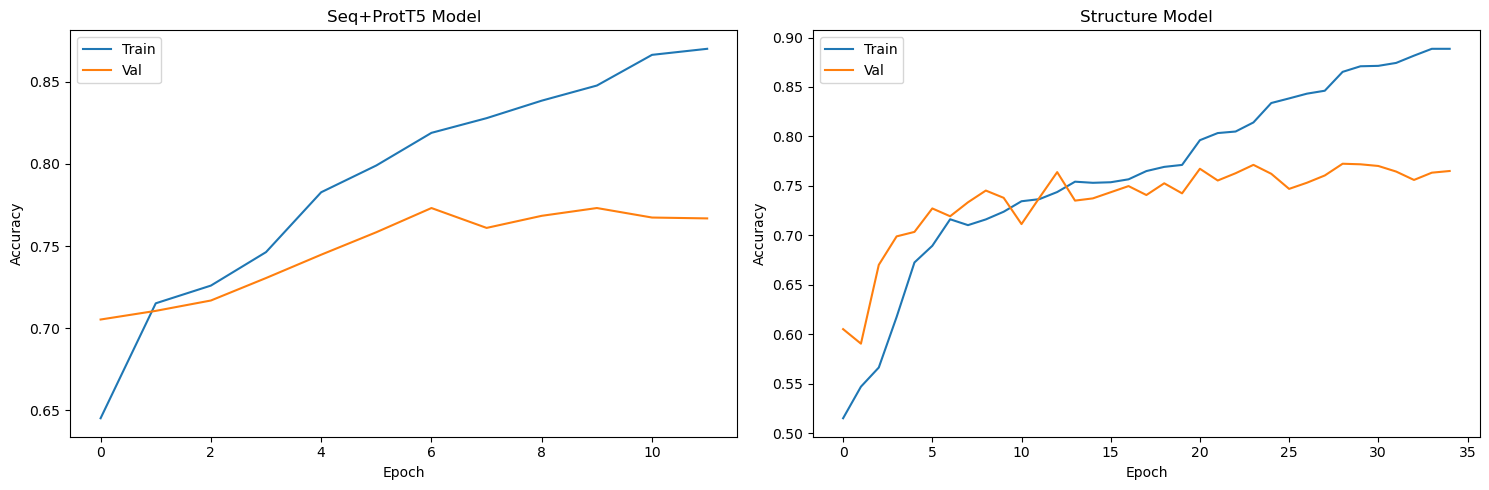


Learned track weights:
Sequence weight: 0.4547
Structure weight: 0.2506
ProtT5 weight: 0.2946
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Validation Results - Sequence+ProtT5 Model:
Accuracy: 0.7732
Balanced Accuracy: 0.7732
MCC: 0.5477
Sensitivity: 0.8084
Specificity: 0.7379
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Validation Results - Structure Model:
Accuracy: 0.7719
Balanced Accuracy: 0.7688
MCC: 0.5464
Sensitivity: 0.8498
Specificity: 0.6878

Making test set predictions...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Final Combined Test Results:
Accuracy: 0.7115
Balanced Accuracy: 0.7639
MCC: 0.2997
Sensitivity: 0.8261
Specificity: 0.7018

Confusion Matrix:
[[2085  886]
 [  44  209]]


In [26]:
if __name__ == "__main__":
    model_with_struct, model_no_struct = train_and_evaluate_split()